# CSNAnalysis Tutorial
### A brief introduction to the use of the CSNAnalysis package
---
**Mar 5, 2018**
*Dickson Lab, Michigan State University*

## Overview

The CSNAnalysis package is a set of tools for network-based analysis of molecular dynamics trajectories.
  CSNAnalysis is an easy interface between enhanced sampling algorithms
  (e.g. WExplore implemented in `wepy`), molecular clustering programs (e.g. `MSMBuilder`), graph analysis packages (e.g. `networkX`) and graph visualization programs (e.g. `Gephi`).

### What are conformation space networks?

A conformation space network is a visualization of a free energy landscape, where each node is a cluster of molecular conformations, and the edges show which conformations can directly interconvert during a molecular dynamics simulation. A CSN can be thought of as a visual representation of a transition matrix, where the nodes represent the row / column indices and the edges show the off-diagonal elements. `CSNAnalysis` offers a concise set of tools for the creation, analysis and visualization of CSNs.

**This tutorial will give quick examples for the following use cases:**

1. Initializing CSN objects from count matrices
2. Trimming CSNs
2. Obtaining steady-state weights from a transition matrix
  * By eigenvalue
  * By iterative multiplication
3. Computing committor probabilities to an arbitrary set of basins
4. Combining graph-based analysis and matrix-based analysis
5. Exporting quantities for visualization with the Gephi program

## Getting started

Clone the CSNAnalysis repository:

```
git clone https://github.com/ADicksonLab/CSNAnalysis.git```

Navigate to the examples directory and install using pip:

```
cd CSNAnalysis
pip install --user -e
```

Go to the examples directory and open this notebook (`examples.ipynb`):

```
cd examples; jupyter notebook```

## Dependencies

I highly recommend using Anaconda and working in a `python3` environment. The `scipy` module should be at least version 0.19.0. CSNAnalysis uses the packages `numpy`, `scipy` and `networkx`.  If these are installed then the following lines of code should run without error:

In [26]:
import numpy as np
import networkx as nx
import scipy

Check to make sure your `scipy` version is > 0.19.0.

In [27]:
scipy.__version__

'0.19.1'

If `CSNAnalysis` was installed (i.e. added to your `sys.path`), then this should also work:

In [28]:
from csnanalysis.csn import CSN
from csnanalysis.matrix import *

This notebook also uses `matplotlib`, to visualize output.

In [29]:
import matplotlib

Great!  Now let's load in the count matrix that we'll use for all the examples here:

In [30]:
count_mat = scipy.sparse.load_npz('matrix.npz')

## Background: Sparse matrices

It's worth knowing a little about sparse matrices before we start. If we have a huge $N$ by $N$ matrix, where $N > 1000$, but most of the elements are zero, it is more efficient to store the data as a sparse matrix.

In [31]:
type(count_mat)

scipy.sparse.coo.coo_matrix

`coo_matrix` refers to "coordinate format", where the matrix is essentially a set of lists of matrix "coordinates" (rows, columns) and data:

In [32]:
rows = count_mat.row
cols = count_mat.col
data = count_mat.data

for r,c,d in zip(rows[0:10],cols[0:10],data[0:10]):
    print(r,c,d)

0 0 382.0
0 651 2.0
0 909 2.0
0 920 2.0
0 1363 1.0
0 1445 2.0
0 2021 5.0
0 2022 7.0
0 2085 4.0
0 2131 1.0


Although it can be treated like a normal matrix ($4000$ by $4000$ in this case):

In [33]:
count_mat.shape

(4000, 4000)

It only needs to store non-zero elements, which are much fewer than $4000^2$:

In [34]:
len(rows)

44163

**OK, let's get started building a Conformation Space Network!**

---

## 1) Initializing CSN objects from count matrices

To get started we need a count matrix, which can be a `numpy` array, or a `scipy.sparse` matrix, or a list of lists:

In [123]:
our_csn = CSN(count_mat,symmetrize=True)

Any of the `CSNAnalysis` functions can be queried using "?"

In [11]:
CSN?

The `our_csn` object now holds three different representations of our data.  The original counts can now be found in `scipy.sparse` format:

In [91]:
our_csn.countmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 44163 stored elements in COOrdinate format>

A transition matrix has been computed from this count matrix according to: 
\begin{equation}
t_{ij} = \frac{c_{ij}}{\sum_j c_{ij}}
\end{equation}

In [92]:
our_csn.transmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 44163 stored elements in COOrdinate format>

where the elements in each column sum to one:

In [93]:
our_csn.transmat.sum(axis=0)

matrix([[ 1.,  1.,  1., ...,  1.,  1.,  1.]])

Lastly, the data has been stored in a `networkx` directed graph:

In [94]:
our_csn.graph

that holds the nodes and edges of our csn, and we can use in other `networkx` functions.  For example, we can calculate the shortest path between nodes 0 and 10:

In [95]:
nx.shortest_path(our_csn.graph,0,10)

[0, 651, 680, 438, 1824, 1342, 2691, 10]

---
## 2) Trimming CSNs

A big benefit of coupling the count matrix, transition matrix and graph representations is that elements can be "trimmed" from all three simultaneously.  The `trim` function will eliminate nodes that are not connected to the main component (by inflow, outflow, or both), and can also eliminate nodes that do not meet a minimum count requirement:

In [124]:
our_csn.trim(min_count=20)

The trimmed graph, count matrix and transition matrix are stored as `our_csn.trim_graph`, `our_csn.trim_countmat` and `our_csn.trim_transmat`, respectively.

In [97]:
our_csn.trim_graph.number_of_nodes()

2281

In [98]:
our_csn.trim_countmat.shape

(2281, 2281)

In [99]:
our_csn.trim_transmat.shape

(2281, 2281)

## 3) Obtaining steady-state weights from the transition matrix

Now that we've ensured that our transition matrix is fully-connected, we can compute its equilibrium weights.  This is implemented in two ways.

First, we can compute the eigenvector of the transition matrix with eigenvalue one:

In [125]:
wt_eig = our_csn.calc_eig_weights()

This can exhibit some instability, especially for low-weight states, so we can also calculate weights by iterative multiplication of the transition matrix, which can take a little longer:

In [126]:
wt_mult = our_csn.calc_mult_weights()

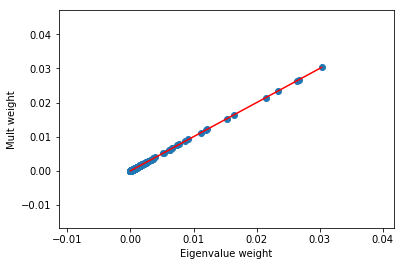

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(wt_eig,wt_mult)
plt.plot([0,wt_mult.max()],[0,wt_mult.max()],'r-')
plt.xlabel("Eigenvalue weight")
plt.ylabel("Mult weight")
plt.show()


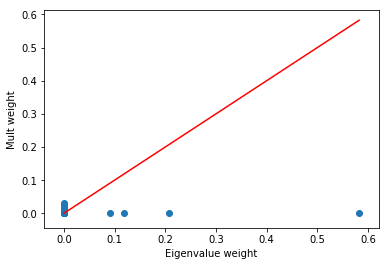

In [122]:
plt.scatter(wt_eig,wt_eig_sym)
plt.plot([0,wt_eig.max()],[0,wt_eig.max()],'r-')
plt.xlabel("Eigenvalue weight")
plt.ylabel("Mult weight")
plt.show()

Although the `eig_weights` are not always positive, especially for low weights:

In [128]:
nx.set_node_attributes?

ValueError: x and y must be the same size

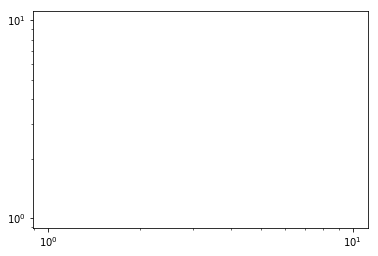

In [117]:
t_wt_eig2 = wt_eig[np.where(wt_eig>0)]
t_wt_mult2 = wt_mult[np.where(wt_eig>0)]
plt.xscale('log')
plt.yscale('log')
plt.scatter(t_wt_eig2,t_wt_mult)
plt.plot([t_wt_mult2.min(),t_wt_mult2.max()],[t_wt_mult2.min(),t_wt_mult2.max()],'r-')

plt.xlabel("Eigenvalue weight")
plt.ylabel("Mult weight")
plt.show()

In [107]:
np.where(wt_eig>0)

(array([  67, 1463, 2301, 2410]),)

In [108]:
t_wt_eig

array([ 0.09942933,  0.21101012,  0.60563917,  0.08392138])

In [43]:
wt_eig.sum()

1.0000000000000002

In [ ]:
cond = np.linalg.cond(our_csn.trim_transmat.toarray())

In [ ]:
cond